 # Image Captioning 

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Import Data_DIR , Work_DIR

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [1]:
from tensorflow.keras.applications import ResNet50
model_res = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94781440/94765736 [==============================] - 0s 0us/step


# Extract Image Features

In [52]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# extract features from image

In [6]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
temp=1

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    print(temp,end=" ")
    temp+=1
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model_res.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

# store features in pickle

In [9]:

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_res.pkl'), 'wb'))

In [3]:

with open(os.path.join(WORKING_DIR, '/kaggle/input/features/features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [5]:

mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [6]:
len(mapping)

8091

# Preprocess Text Data

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:

clean(mapping)

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

40455

In [12]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [13]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

8485

In [15]:

max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [91]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 

In [89]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [105]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Attention, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)  
fe2 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fe1)  # L2 regularization


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)  
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)  


attention = Attention()([se3, se3])  
se4 = LSTM(256)(attention)  

# Decoder
decoder1 = add([fe2, se4])  # Combine features
decoder2 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(decoder1)  # Regularized
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile with Adam and lower initial LR
optimizer = Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

In [31]:
epochs = 50 
batch_size = 16


train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(train)//batch_size,
    validation_steps=len(test)//batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
455/455 [==============================] - 130s 267ms/step - loss: 9.6555 - accuracy: 0.1195 - val_loss: 7.1147 - val_accuracy: 0.1398
Epoch 2/50


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


455/455 [==============================] - 118s 260ms/step - loss: 6.2707 - accuracy: 0.1519 - val_loss: 5.6770 - val_accuracy: 0.1696
Epoch 3/50
455/455 [==============================] - 118s 259ms/step - loss: 5.3461 - accuracy: 0.1820 - val_loss: 5.1188 - val_accuracy: 0.1919
Epoch 4/50
455/455 [==============================] - 118s 260ms/step - loss: 4.9262 - accuracy: 0.1967 - val_loss: 4.8522 - val_accuracy: 0.2005
Epoch 5/50
455/455 [==============================] - 118s 259ms/step - loss: 4.7185 - accuracy: 0.2033 - val_loss: 4.7275 - val_accuracy: 0.2055
Epoch 6/50
455/455 [==============================] - 118s 260ms/step - loss: 4.5963 - accuracy: 0.2090 - val_loss: 4.6472 - val_accuracy: 0.2107
Epoch 7/50
455/455 [==============================] - 118s 260ms/step - loss: 4.5102 - accuracy: 0.2161 - val_loss: 4.5874 - val_accuracy: 0.2191
Epoch 8/50
455/455 [==============================] - 118s 260ms/step - loss: 4.4417 - accuracy: 0.2232 - val_loss: 4.5389 - val_accura

In [32]:
model.save('upgraded_cap_gen__resnet50.h5')

In [33]:
model.save('upgraded_resnet50_sa.keras')

In [40]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


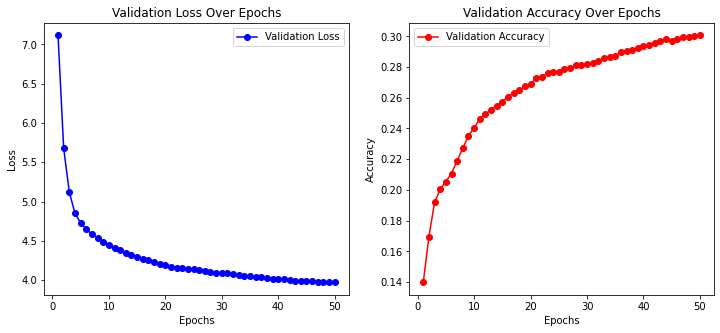

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots validation loss and validation accuracy over epochs."""
    epochs = range(1, len(history.history['val_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['val_loss'], 'bo-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.show(block=True)  # Force the plot to display

# Call this after training
plot_training_history(history)


# Generate Captions for the Image

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:

def predict_caption(model, image, tokenizer, max_length):

    in_text = 'startseq'

    for i in range(max_length):

        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model2, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
#from nltk.translate.bleu_score import corpus_bleu,bleu_score
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu,SmoothingFunction

# validate with test data
actual, predicted = list(), list()
smooth = SmoothingFunction().method4
temp=1

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model2, features[key], tokenizer, max_length) 
    print(temp,end=" ")
    temp+=1
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
  

In [28]:
  
# calcuate BLEU score
print("BLEU-1: %f" % sentence_bleu(actual, predicted,smoothing_function=smooth))
#print("BLEU-2: %f" % sentence_b(actual, predicted))

In [38]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

actual, predicted = list(), list()
smooth = SmoothingFunction().method4
temp = 1
bleu_scores = []  # Store BLEU scores for each sentence

for key in tqdm(test):
    # Get actual captions (list of tokenized captions)
    captions = mapping[key]
    actual_captions = [caption.split() for caption in captions]
    
    # Predict caption (tokenized)
    y_pred = predict_caption(model, features[key], tokenizer, max_length).split()
    
    # Compute BLEU for this sentence and store it
    bleu = sentence_bleu(actual_captions, y_pred, smoothing_function=smooth)
    bleu_scores.append(bleu)
    #print(bleu, end=" ")
    
    # Append to lists (optional, if you still want to compute corpus BLEU later)
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    print(temp, end=" ")
    temp += 1

# Compute average BLEU-1 across all sentences
avg_bleu1 = np.mean(bleu_scores)
print("\nAverage Sentence BLEU-1:", avg_bleu1)

  0%|          | 0/810 [00:00<?, ?it/s]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [94]:
generate_caption("1001773457_577c3a7d70.jpg")
model.save('upgraded75epoch.keras')

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

---------------------Actual---------------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------------Predicted--------------------
startseq man in darkened room with light white tarp endseq


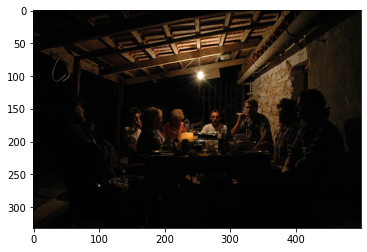

In [31]:
generate_caption("107582366_d86f2d3347.jpg")

In [24]:
from tensorflow.keras.models import load_model

model2 = load_model('/kaggle/input/models/best_model_150epoch_continue_training.h5')

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      2172160     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
____________________________________________________________________________________________

In [104]:
model2.save('epo150_3.keras',save_format='keras')

---------------------Actual---------------------
startseq family playing on tractor on beautiful day endseq
startseq children ride tractor in field endseq
startseq several children playing on polaris vehicle outdoors endseq
startseq the children played on the four wheeler in the field endseq
startseq the four kids are riding on an atv in field endseq
--------------------Predicted--------------------
startseq boy in red shirt is riding bike through the grass endseq


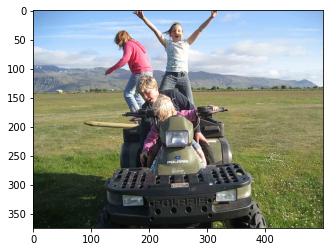

In [39]:
generate_caption("1087539207_9f77ab3aaf.jpg")

In [33]:
import matplotlib.pyplot as plt

# Extract validation loss
val_loss = history.history['val_loss']

# Plot validation loss
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


KeyError: 'val_loss'

In [35]:
history.history.keys()

dict_keys(['loss'])

In [17]:
# load vgg16 model
model_vgg= VGG16()

model_vgg = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-2].output)

#print(model2.summary())

553476096/553467096 [==============================] - 21s 0us/step


Testing 


--------------------predicted--------------------
startseq the man is sitting on the floor with his arms out endseq


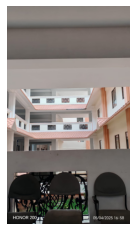

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


def preprocess_image(image_path, target_size=(224, 224)): 
    image = load_img(image_path, target_size=target_size)  
    image = img_to_array(image) / 255.0  
    image = np.expand_dims(image, axis=0)  
    return image

# Load test image
image_path = "/kaggle/input/building/building.jpg"  
image = load_img(image_path)  


image_input = preprocess_image(image_path)
features = model_vgg.predict(image_input) 

y_pred = predict_caption(model2, features, tokenizer, max_length)  


print('--------------------predicted--------------------')
print(y_pred)
plt.imshow(image)
plt.axis("off")
plt.show()


### 